## Questing Answering on SQuAD dataset

### Import libraries

In [1]:
import json
import pandas as pd
import os
import random

import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from typing import List, Callable, Dict
from nltk.stem import WordNetLemmatizer

from datetime import datetime
import keras
from keras import backend as K
from keras.layers import Concatenate, Lambda, LSTM, Reshape, Dense, Embedding, Average, Reshape, Flatten, Input, Add, Bidirectional, TimeDistributed, Softmax
from keras.models import Model 
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
import zipfile
from keras.utils.np_utils import to_categorical
#from keras.layers.advanced_activations import Softmax


## Data pipeline

#### Load dataset

In [2]:
def load_json(filename="training_set.json", folder="SQUAD MATERIAL"):    
    dataset_folder = os.path.join(os.getcwd(), folder)
    dataset_path = os.path.join(dataset_folder, filename)
    with open(dataset_path) as f:
        raw_json = json.load(f)

    return raw_json['data']

In [3]:
data = load_json()

#### Split dataset into train, val and test sets.
Splitting on title, so that all answers and questions in one title are in the same dataset

In [4]:
def split_dataset(data):
    random.shuffle(data)
    length_of_dataset = len(data)
    train_split = round(0.8*length_of_dataset)
    val_split = train_split + round(0.1*length_of_dataset)
    train_data = data[:train_split]
    val_data = data[train_split:val_split]
    test_data = data[val_split:]
    return train_data, val_data, test_data

In [5]:
train_data, val_data, test_data = split_dataset(data)

#### Create dataframe

In [6]:
def find_word_index(char_idx, context):
    return context[0:char_idx].count(' ')

In [7]:
def create_dataframe(data):
    contexts = []
    questions = []
    answers_text = []
    answers_start = []
    answers_end = []
    question_ids = []
    answers_word_start = []
    answers_word_end = []
    for i in range(len(data)):
        paragraphs = data[i]['paragraphs']
        for sub_para in paragraphs:
            for q_a in sub_para['qas']:
                questions.append(q_a['question'])
                q_a_answer_starts = []
                q_a_answer_ends = []
                q_a_answers = []
                q_a_ans_word_idx_start = []
                q_a_ans_word_idx_end = []

                for answer in q_a['answers']:
                    answer_end = answer['answer_start'] + len(answer['text'])
                    q_a_answer_starts.append(answer['answer_start'])
                    q_a_answer_ends.append(answer_end)
                    q_a_answers.append(answer['text'])
                    q_a_ans_word_idx_start.append(find_word_index(answer['answer_start'], sub_para['context']))
                    q_a_ans_word_idx_end.append(find_word_index(answer_end, sub_para['context']))
                    
                answers_start.append(q_a_answer_starts)
                answers_end.append(q_a_answer_ends)
                answers_word_start.append(q_a_ans_word_idx_start)                
                answers_word_end.append(q_a_ans_word_idx_end)
                answers_text.append(q_a_answers)
                question_ids.append(q_a['id'])
                contexts.append(sub_para['context'])   
    df = pd.DataFrame({"questionID":question_ids, "context":contexts, "question": questions, "answer_start": answers_start, "answer_word_start": answers_word_start, "answer_end": answers_end, "answer_word_end": answers_word_end, "answer_text": answers_text})
    return df

In [8]:
train_df = create_dataframe(train_data)
val_df = create_dataframe(val_data)
test_df = create_dataframe(test_data)

In [9]:
train_df

,questionID,context,question,answer_start,answer_word_start,answer_end,answer_word_end,answer_text
0,56dfb9227aa994140058e079,An Internet service provider (ISP) is an organ...,What does ISP stand for?,[3],[1],[28],[3],[Internet service provider]
1,56dfb9227aa994140058e07a,An Internet service provider (ISP) is an organ...,what does an isp do?,[59],[9],[111],[15],"[provides services for accessing, using, the I..."
2,56dfb9227aa994140058e07b,An Internet service provider (ISP) is an organ...,What forms can an isp be organized in?,[183],[27],[252],[33],"[commercial, community-owned, non-profit, or o..."
3,56dfb9837aa994140058e083,Internet services typically provided by ISPs i...,What type of organization provides internet ac...,[40],[5],[44],[5],[ISPs]
4,56dfb9837aa994140058e084,Internet services typically provided by ISPs i...,What are some services provided by an isp?,[53],[7],[157],[19],"[Internet access, Internet transit, domain nam..."
...,...,...,...,...,...,...,...,...
72025,570feb3480d9841400ab372b,"In 2006, Dell acknowledged that it had problem...",What amount did Dell increase its customer ser...,[375],[66],[387],[67],[$150 million]
72026,570feb9480d9841400ab372f,The company aims to reduce its external enviro...,What does Dell aim to reduce by creating energ...,[31],[6],[60],[8],[external environmental impact]
72027,570feb9480d9841400ab3730,The company aims to reduce its external enviro...,How much does energy efficiency save Dell per ...,[265],[33],[275],[34],[$3 million]
72028,570feb9480d9841400ab3731,The company aims to reduce its external enviro...,What is the largest contributor to Dell's ener...,[397],[50],[416],[52],[PC power management]


## Clean and transform data

#### Clean text
What should we do? just lowering everyhting? remove stopwords? how will that work with the answer start number???

In [10]:
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()    

def lemmatize_words(text: str ) -> str:
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

PREPROCESSING_PIPELINE = [
                          lower,
                          strip_text
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    if type(text) == list:
        new_row = [reduce(lambda txt, f: f(txt), filter_methods, x) for x in text]
    else:
        new_row = reduce(lambda txt, f: f(txt), filter_methods, text)
    return new_row

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/solveig.mohr/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
to_be_cleaned = ["context", "question", "answer_text"]
for key in to_be_cleaned:
    train_df[key] = train_df[key].apply(lambda txt: text_prepare(txt))
    val_df[key] = val_df[key].apply(lambda txt: text_prepare(txt))
    test_df[key] = test_df[key].apply(lambda txt: text_prepare(txt))
    

#### Make tokenixer

### THINGS TO THINK ABOUT
- Now its the padding is exstream! The questions has to be 3706 caracters long!
- We are only fitting on text the train context and questions. Should this also be done for val/train?
- Preprocessing is only lowering the words. Should we do more, like removing stopwords? In that case we need to consider the answer_start index. This has to be corrected after removal of carachters
- OOV are handeled with index 1 and will all have weights 0 in the beginning. is this correct?


In [12]:
# The tokenizer will have an index 1 for OOV words. A lot of words in test and val will be 1.
tokenizer = Tokenizer(oov_token=1)

tokenizer.fit_on_texts(train_df["context"])
tokenizer.fit_on_texts(train_df["question"])

In [13]:
# Find max sentence lenght for the context
MAX_SEQ_LEN = np.max([len(row.split(' ')) for row in train_df["context"]])

In [14]:
MAX_SEQ_LEN

653

In [15]:
def textToTensor(tokenizer, max_len, text):
    '''
        Converts text to tensors by converting the words into the correct indexes. 
        Then padds the tensors with 0 vlaues
    '''
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences=seq, maxlen=max_len, padding='post')
    return padded

In [16]:
context_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["context"])
question_train = textToTensor(tokenizer, MAX_SEQ_LEN, train_df["question"])

context_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["context"])
question_val = textToTensor(tokenizer, MAX_SEQ_LEN, val_df["question"])

context_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["context"])
question_test = textToTensor(tokenizer, MAX_SEQ_LEN, test_df["question"])

In [17]:
# Takes only the first answer: simplification
# Can do this because we know there are only one answer for each question in our dataset
# Might need to change this
index_start_train = to_categorical(np.array(train_df["answer_word_start"].str[0]), num_classes=MAX_SEQ_LEN)
index_end_train = to_categorical(np.array(train_df["answer_word_end"].str[0]), num_classes=MAX_SEQ_LEN)

index_start_val = to_categorical(np.array(val_df["answer_word_start"].str[0]), num_classes=MAX_SEQ_LEN)
index_end_val = to_categorical(np.array(val_df["answer_word_end"].str[0]), num_classes=MAX_SEQ_LEN)

index_start_test = np.array(train_df["answer_word_start"].str[0])
index_end_test = np.array(train_df["answer_word_end"].str[0])

index_start_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
# Find size of vocabulary
VOCABULARY_SIZE = len(tokenizer.word_index) + 1

### Applying glove

In [19]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model
    
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix


In [20]:
embedding_dimension = 50

embedding_model = load_embedding_model(embedding_dimension)
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index)
embedding_matrix.shape

(81045, 50)

### Create model

In [21]:
# convenience l2_norm function
def l2_norm(x, axis=None):
    """
    takes an input tensor and returns the l2 norm along specified axis
    """

    square_sum = K.sum(K.square(x), axis=axis, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))

    return norm

def pairwise_cosine_sim(A_B):
    """
    A [batch x n x d] tensor of n rows with d dimensions
    B [batch x m x d] tensor of n rows with d dimensions

    returns:
    D [batch x n x m] tensor of cosine similarity scores between each point i<n, j<m
    """

    A, B = A_B
    A_mag = l2_norm(A, axis=2)
    B_mag = l2_norm(B, axis=2)
    num = K.batch_dot(A, K.permute_dimensions(B, (0,2,1)))
    den = (A_mag * K.permute_dimensions(B_mag, (0,2,1)))
    dist_mat =  num / den

    return dist_mat

In [22]:
def similarity(A_B):
    """
    A [batch x n x d] tensor of n rows with d dimensions
    B [batch x m x d] tensor of n rows with d dimensions

    returns:
    D [batch x n x m] tensor of cosine similarity scores between each point i<n, j<m
    """
    A, B = A_B
    element_wise_multiplication = A * B
    concated = K.concatenate([A, B, element_wise_multiplication], axis=-1)
    kernel = tf.keras.layers.Layer.add_weigths(name='similarity_weight',
                                        shape=(concated.shape[-1], 1),
                                        initializer='uniform',
                                        trainable=True)
    
    dot_product = K.squeeze(K.dot(concated, kernel), axis=-1)
    return dot_product

##### Similarity matrix

In [81]:
from tensorflow.keras.layers import Layer
class Similarity(Layer):

    def __init__(self, **kwargs):
        super(Similarity, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*3
        self.kernel = self.add_weight(name='similarity_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(Similarity, self).build(input_shape)
    def get_kernel(self):
        return self.kernel
    
    def call(self, inputs):
        A, B = inputs
        A_dim_repeat = K.concatenate([[1, 1], [A.shape[1]], [1]], 0)
        B_dim_repeat = K.concatenate([[1], [B.shape[1]], [1, 1]], 0)
        A_repeated = K.tile(K.expand_dims(A, axis=2), A_dim_repeat)
        B_repeated = K.tile(K.expand_dims(B, axis=1), B_dim_repeat)
        element_wise_multiplication = A_repeated * B_repeated
        concated = K.concatenate([A_repeated, B_repeated, element_wise_multiplication], axis=-1)
        dot= K.dot(concated, self.kernel)
        dot_product = K.squeeze(dot, axis=-1)
        return dot_product

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        num_context_words = input_shape[0][1]
        num_query_words = input_shape[1][1]
        return (batch_size, num_context_words, num_query_words)

##### testing

In [82]:
sim = Similarity()

In [26]:
#sim([A, B])

NameError: name 'A' is not defined

In [ ]:
sim.get_kernel()

<tf.Variable 'similarity_1/similarity_weight:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.0150565 ],
       [-0.00643172],
       [ 0.03498759],
       [-0.02662505],
       [-0.03315787],
       [-0.02331753],
       [ 0.00396756],
       [-0.04221762],
       [-0.03750741]], dtype=float32)>

In [ ]:
A = K.constant([[[1,1,1], [2,2,2], [3,3,3], [8,8,8]],[[1,1,1], [2,2,2], [3,3,3],[8,8,8]]])
B = K.constant([[[4,4,4], [5,5,5], [6,6,6], [7,7,7]],[[4,4,4], [5,5,5], [6,6,6], [7,7,7]]])
print(A.shape)
print(B.shape)

(2, 4, 3)
(2, 4, 3)


In [ ]:


A_dim_repeat = K.concatenate([[1, 1], [A.shape[1]], [1]], 0)
B_dim_repeat = K.concatenate([[1], [B.shape[1]], [1, 1]], 0)
A_repeated = K.tile(K.expand_dims(A, axis=2), A_dim_repeat)
B_repeated = K.tile(K.expand_dims(B, axis=1), B_dim_repeat)
kernel = K.constant([[1], [1], [1], [1], [1], [1], [1], [1], [1]])
print(kernel.shape)
element_wise_multiplication = A_repeated * B_repeated
concated = K.concatenate([A_repeated, B_repeated, element_wise_multiplication], axis=-1)
print(concated.shape)
dot= K.dot(concated, kernel)
dot_product = K.squeeze(dot, axis=-1)

(9, 1)
(2, 4, 4, 9)


In [ ]:
dot_product

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 27.,  33.,  39.,  45.],
        [ 42.,  51.,  60.,  69.],
        [ 57.,  69.,  81.,  93.],
        [132., 159., 186., 213.]],

       [[ 27.,  33.,  39.,  45.],
        [ 42.,  51.,  60.,  69.],
        [ 57.,  69.,  81.,  93.],
        [132., 159., 186., 213.]]], dtype=float32)>

In [ ]:
Softmax(axis=-1)(dot_product)

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[1.5192230e-08, 6.1289825e-06, 2.4726081e-03, 9.9752122e-01],
        [1.8792968e-12, 1.5228101e-08, 1.2339458e-04, 9.9987662e-01],
        [2.3195084e-16, 3.7751115e-11, 6.1441742e-06, 9.9999380e-01],
        [6.6396770e-36, 3.5326288e-24, 1.8795287e-12, 1.0000000e+00]],

       [[1.5192230e-08, 6.1289825e-06, 2.4726081e-03, 9.9752122e-01],
        [1.8792968e-12, 1.5228101e-08, 1.2339458e-04, 9.9987662e-01],
        [2.3195084e-16, 3.7751115e-11, 6.1441742e-06, 9.9999380e-01],
        [6.6396770e-36, 3.5326288e-24, 1.8795287e-12, 1.0000000e+00]]],
      dtype=float32)>

In [ ]:
Dense(units=4, activation='softmax')(dot_product)

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[1.0000000e+00, 2.0097726e-10, 2.7750147e-31, 1.4798254e-26],
        [1.0000000e+00, 1.6577712e-15, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 1.3674291e-20, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[1.0000000e+00, 2.0097726e-10, 2.7750147e-31, 1.4798254e-26],
        [1.0000000e+00, 1.6577712e-15, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 1.3674186e-20, 0.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]],
      dtype=float32)>

In [ ]:
c =K.constant([[[1,1,1], [2,2,2], [3,3,3], [8,8,8]],[[1,1,1], [2,2,2], [3,3,3],[8,8,8]]])
d = K.constant([[[2,3,4,5], [1,1,1,1], [1,1,1,1], [1,1,1,1]], [[1,1,1,1], [1,1,1,1], [1,1,1,1], [1,1,1,1]]])
print(c.shape)
print(d.shape)

(2, 4, 3)
(2, 4, 4)


In [ ]:
c

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [8., 8., 8.]],

       [[1., 1., 1.],
        [2., 2., 2.],
        [3., 3., 3.],
        [8., 8., 8.]]], dtype=float32)>

In [ ]:
d2 = K.expand_dims(d, axis=-1)
d2.shape

TensorShape([2, 4, 4, 1])

In [ ]:
c2 = K.expand_dims(c, axis=1)
c2.shape

TensorShape([2, 1, 4, 3])

In [ ]:
K.sum(d2*c2, axis=-2)

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[60., 60., 60.],
        [14., 14., 14.],
        [14., 14., 14.],
        [14., 14., 14.]],

       [[14., 14., 14.],
        [14., 14., 14.],
        [14., 14., 14.],
        [14., 14., 14.]]], dtype=float32)>

In [ ]:
max_sim_matrix = K.max(d, axis=-1)
softmax_similarity_matrix = Softmax(axis=-1)(max_sim_matrix)

In [ ]:
d

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[2., 3., 4., 5.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]],

       [[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]], dtype=float32)>

In [ ]:
max_sim_matrix

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[5., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)>

In [ ]:
softmax_similarity_matrix

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0.9479149 , 0.01736167, 0.01736167, 0.01736167],
       [0.25      , 0.25      , 0.25      , 0.25      ]], dtype=float32)>

##### C2q

In [83]:
class Context2QuestionAttention(Layer):
    '''
    A = Take row-wise softmax of the similarity matrix
    Û = For every row in A (softmaxed similarity matrix), A_t:
        Multiply every element in A_t calculate the weighted sum of the question matrix. 
        (The weigths will be the elements in A_t)
    Input: Question matrix and similarity matrix
    '''
    def __init__(self, **kwargs):
        super(Context2QuestionAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(Context2QuestionAttention, self).build(input_shape)


    
    def call(self, inputs):
        question_encoding, similarity_matrix = inputs
        masked_inp = tf.where(similarity_matrix!=0, similarity_matrix, tf.float64.min)
        softmax_similarity_matrix = Softmax(axis=-1)(masked_inp)
        question_encoding_expand = K.expand_dims(question_encoding, axis=1)
        softmax_similarity_matrix_expand = K.expand_dims(softmax_similarity_matrix, axis=-1)
        product = softmax_similarity_matrix_expand*question_encoding_expand
        summ = K.sum(product, axis=-2)
        return summ

    def compute_output_shape(self, input_shape):
        question_encoding_shape, _ = input_shape
        batch_size = question_encoding_shape[0]
        max_seq_len = question_encoding_shape[1]
        embedding_dim = question_encoding_shape[2]
        return (batch_size,max_seq_len, embedding_dim)

##### q2c

In [84]:
class Question2ContextAttention(Layer):
    '''
    Similraity matrix [max_seq_len, max_seq_len]
    Z = maximum across each row of the similarity matrix [max_seq_len, 1]
    b = softmax on Z to get attention distribution (max_seq_len, 1)
    ^h = Use b to take a weigthed sum of the contex matrix H (max_seq_len, 1)
    ^H = ^h dubplicated max_seq_len times (max_seq_len, max_seq_len)
    '''
    
    def __init__(self, **kwargs):
        super(Question2ContextAttention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(Question2ContextAttention, self).build(input_shape)
    
    def call(self, inputs):
        context_encoding, similarity_matrix = inputs
        max_sim_matrix = K.max(similarity_matrix, axis=-1) # K.max also squeezes
        print('sim_matrix', similarity_matrix)
        print('max_sim_matrix', max_sim_matrix)
        masked_inp = tf.where(max_sim_matrix!=0, max_sim_matrix, tf.float64.min)
        softmax_similarity_matrix = Softmax(axis=-1)(masked_inp)
        softmax_similarity_matrix_expand = K.expand_dims(softmax_similarity_matrix, axis=-1)
        product = softmax_similarity_matrix_expand*context_encoding
        weighted_sum = K.sum(product, axis=-2)
        # Expand dimensions, so that vector can be repeated
        expanded_weighted_sum = K.expand_dims(weighted_sum, 1)
        # get max_seq_len
        max_seq_len = K.shape(context_encoding)[1]
        # repeat vector for max seq length to make matrix
        question2context_attention = K.tile(expanded_weighted_sum, [1, max_seq_len, 1])
        return question2context_attention

    def compute_output_shape(self, input_shape):
        batch_size = input_shape[0][0]
        num_context_words = input_shape[0][1]
        num_query_words = input_shape[1][1]
        return (batch_size, num_context_words, num_query_words)

##### Mega merge

In [85]:
class MegaMerge(Layer):
    '''
    For each word in max_seqence_length (T):
        cu = context elementwise multiply with Û (c2q) (2d, T)
        ch = context elementwise multiply with ^H (q2c) (2d, T)
        Stack for each column context, Û, cu, ch. [8*embedding_dim, 1]
    Output:
    mega_merge (8d, T)

    '''
    
    def __init__(self, **kwargs):
        super(MegaMerge, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(MegaMerge, self).build(input_shape)
    
    def call(self, inputs):
        context_encoding, context2question_attention, question2context_attention = inputs

        element_wise_multiply1 = context_encoding * context2question_attention
        element_wise_multiply2 = context_encoding * question2context_attention

        mega_merge = K.concatenate([context_encoding, context2question_attention, element_wise_multiply1, element_wise_multiply2], axis=-1)
        return mega_merge

    def compute_output_shape(self, input_shape):
        context_encoding_shape , _, _ = input_shape
        batch_size = context_encoding_shape[0]
        max_seq_len = context_encoding_shape[1]
        embedding_dim2 = context_encoding_shape[2]
        return (batch_size, max_seq_len, embedding_dim2*4)

##### Output layer start

In [108]:
class StartOutput(Layer):
    '''
    1. super merge = Concatenate first hidden_layer(T,2d) with Mega merge(T,8d)
    Make trainable weigths (10d, 1)
    2. dotted = Dotproduct with trainable weigths and super merge (T,1)
    3. out = Softmax the dotted vector (T,1)
    Output:
    out (T,1)

    '''
    
    def __init__(self, **kwargs):
        super(StartOutput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*5 # want 10*embedding dimention
        self.kernel = self.add_weight(name='startOutput_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(StartOutput, self).build(input_shape)
    
    def call(self, inputs):
        hidden_layer, mega_merge, mask = inputs
        super_merge = K.concatenate([mega_merge, hidden_layer])

        dotted = K.squeeze(K.dot(super_merge, self.kernel), axis=-1)
        print('start, before softmax:', dotted[0][:33])
        print('mask', mask)
        print('shape mask', mask.shape)
        masked_inp = tf.where(mask!=False, dotted, tf.float64.min)
        soft_max_dotted = Softmax(axis=-1)(masked_inp)
        return soft_max_dotted

    def compute_output_shape(self, input_shape):
        hidden_layer , _, _ = input_shape
        batch_size = hidden_layer[0]
        max_seq_len = hidden_layer[1]
        return (batch_size, max_seq_len, 1)

In [109]:
class EndOutput(Layer):
    '''
    1. super merge = Concatenate second hidden layer with Mega merge
    Make trainable weigths (10d, 1)
    2. dotted = Dotproduct with trainable weigths and super merge (T,1)
    3. out = Softmax the dotted vector (T,1)
    Output:
    out (T,1)

    '''
    
    def __init__(self, **kwargs):
        super(EndOutput, self).__init__(**kwargs)
    
    def build(self, input_shape):
        shape = input_shape[0][-1]*5 # want 10*embedding dimention
        self.kernel = self.add_weight(name='startOutput_weight',
                                        shape=(shape, 1),
                                        initializer='uniform',
                                        trainable=True)
        super(EndOutput, self).build(input_shape)
    
    def call(self, inputs):
        hidden_layer, mega_merge, mask = inputs
        super_merge = K.concatenate([mega_merge, hidden_layer])

        dotted = K.dot(super_merge, self.kernel)
        masked_inp = tf.where(mask!=False, dotted, tf.float64.min)
        soft_max_dotted = Softmax(axis=-1)(masked_inp)
        return soft_max_dotted

    def compute_output_shape(self, input_shape):
        hidden_layer , _, _ = input_shape
        batch_size = hidden_layer[0]
        max_seq_len = hidden_layer[1]
        return (batch_size, max_seq_len, 1)

##### Create model

In [93]:
def create_model(max_tokens, vocab_size, embedding_dimension):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimension of the embedding vectors
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    question_input = Input(shape=(max_tokens, ))
    context_input = Input(shape=(max_tokens, ))
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Word embedding ------------------------------------------------------------
    question_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_question', trainable = False, mask_zero = True)(question_input)
    context_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)(context_input)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Encoding/sentence embedding -------------------------------------------------------
    # Encode token sequences with bi-directional LSTM and concatenate the series of hidden vectors (done by default)
    question_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims'))(question_embedding)
    context_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence'))(context_embedding)
    #-----------------------------------------------------------------------------------------------------
    
    #-------------------------- Similarity ------------------------------------------------------------
    similarity_layer = Similarity()
    similarity_matrix = similarity_layer([question_encoding, context_encoding])
    #-------------------------- Attention ------------------------------------------------------------
    c2q = Context2QuestionAttention()
    context2question_attention = c2q([question_encoding, similarity_matrix])

    q2c = Question2ContextAttention()
    question2context_attention = q2c([context_encoding, similarity_matrix])
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Megamerge --------------------------------------------------------------
    mm = MegaMerge()
    mega_merge = mm([context_encoding, context2question_attention, question2context_attention])
    #-------------------------- Model layer --------------------------------------------------------------

    hidden_layer = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(mega_merge)
    hidden_layer2 = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(hidden_layer)

    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Output layer -------------------------------------------------------------
    # OBS addef the mask to remove padding
    emb = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)
    mask = emb.compute_mask(context_input)
    start_out_model = StartOutput()
    start_probabilities = start_out_model([hidden_layer, mega_merge, mask])

    end_out_model = EndOutput()
    end_probabilities = end_out_model([hidden_layer2, mega_merge, mask])

    return Model(inputs=[question_input, context_input], outputs=[start_probabilities, end_probabilities])



In [66]:
model = create_model(MAX_SEQ_LEN, VOCABULARY_SIZE, 50)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 653)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 653)]        0           []                               
                                                                                                  
 WordEmbedding_context (Embeddi  (None, 653, 50)     4029400     ['input_8[0][0]']                
 ng)                                                                                              
                                                                                                  
 WordEmbedding_question (Embedd  (None, 653, 50)     4029400     ['input_7[0][0]']          

In [110]:
def create_model_mock(max_tokens, vocab_size, embedding_dimension, q_input, c_input):
    '''
        Creates keras model for classification.
        Inputs: 
            max_tokens (int): Max length of a text sequence
            vocab_size (int): Size of the vocabulary
            embedding_dimension (int): The dimension of the embedding vectors
    '''   

    #-------------------------- Input layer ------------------------------------------------------------
    question_input = q_input
    context_input = c_input
    #-----------------------------------------------------------------------------------------------------
    print('q_input:', question_input)
    print('c_input:', context_input)
    #-------------------------- Word embedding ------------------------------------------------------------
    question_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_question', trainable = False, mask_zero = True)(question_input)
    context_embedding = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)(context_input)
    #-----------------------------------------------------------------------------------------------------
    print('q_embedding: ', question_embedding)
    print('c_embedding: ', context_embedding)

    #-------------------------- Encoding/sentence embedding -------------------------------------------------------
    # Encode token sequences with bi-directional LSTM and concatenate the series of hidden vectors (done by default)
    question_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_claims'))(question_embedding)
    context_encoding = Bidirectional(LSTM(embedding_dimension, return_sequences=True, name='SentenceEmbedding_evidence'))(context_embedding)
    #-----------------------------------------------------------------------------------------------------
    print('q_encoding: ', question_encoding)
    print('c_encoding: ', context_encoding)
    #-------------------------- Similarity ------------------------------------------------------------
    similarity_layer = Similarity()
    similarity_matrix = similarity_layer([question_encoding, context_encoding])

    print('Similarity: ', similarity_matrix)
    #-------------------------- Attention ------------------------------------------------------------
    c2q = Context2QuestionAttention()
    context2question_attention = c2q([question_encoding, similarity_matrix])

    q2c = Question2ContextAttention()
    question2context_attention = q2c([context_encoding, similarity_matrix])

    print('c2q_attention: ', context2question_attention)
    print('question2context_attention: ', question2context_attention)
    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Megamerge --------------------------------------------------------------
    mm = MegaMerge()
    mega_merge = mm([context_encoding, context2question_attention, question2context_attention])
    print('mega_merge: ', mega_merge)
    #-------------------------- Model layer --------------------------------------------------------------

    hidden_layer = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(mega_merge)
    hidden_layer2 = Bidirectional(LSTM(embedding_dimension, return_sequences=True))(hidden_layer)
    print('hidden_layer: \n', hidden_layer)
    print('hidden_layer2: \n', hidden_layer2)

    #-----------------------------------------------------------------------------------------------------

    #-------------------------- Output layer -------------------------------------------------------------
    #OBS ADDED THIS:
    emb = Embedding(vocab_size, embedding_dimension, weights = [embedding_matrix], name='WordEmbedding_context', trainable = False, mask_zero = True)
    mask = emb.compute_mask(context_input)
    start_out_model = StartOutput()
    start_probabilities = start_out_model([hidden_layer, mega_merge, mask])

    end_out_model = EndOutput()
    end_probabilities = end_out_model([hidden_layer2, mega_merge, mask])

    print('start: ', start_probabilities, '\nend: \n', end_probabilities)

In [63]:
question_train[0:1].shape

(1, 653)

In [111]:
create_model_mock(MAX_SEQ_LEN, VOCABULARY_SIZE, 50, question_train[0:1], context_train[0:1])

q_input: [[  17  137 7930 2096   11    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    

In [62]:
model.compile(loss='mse',
              optimizer='Adam',
              metrics=['acc'])
history = model.fit(x=[context_train, question_train], y=[index_start_train, index_end_train], batch_size=1, epochs=2, validation_data=([context_val, question_val], [index_start_val, index_end_val]))

Epoch 1/2
  132/69377 [..............................] - ETA: 37:02:56 - loss: 1.9969 - start_output_1_loss: 0.9985 - end_output_1_loss: 0.9985 - start_output_1_acc: 0.0015 - end_output_1_acc: 0.0015

KeyboardInterrupt: 

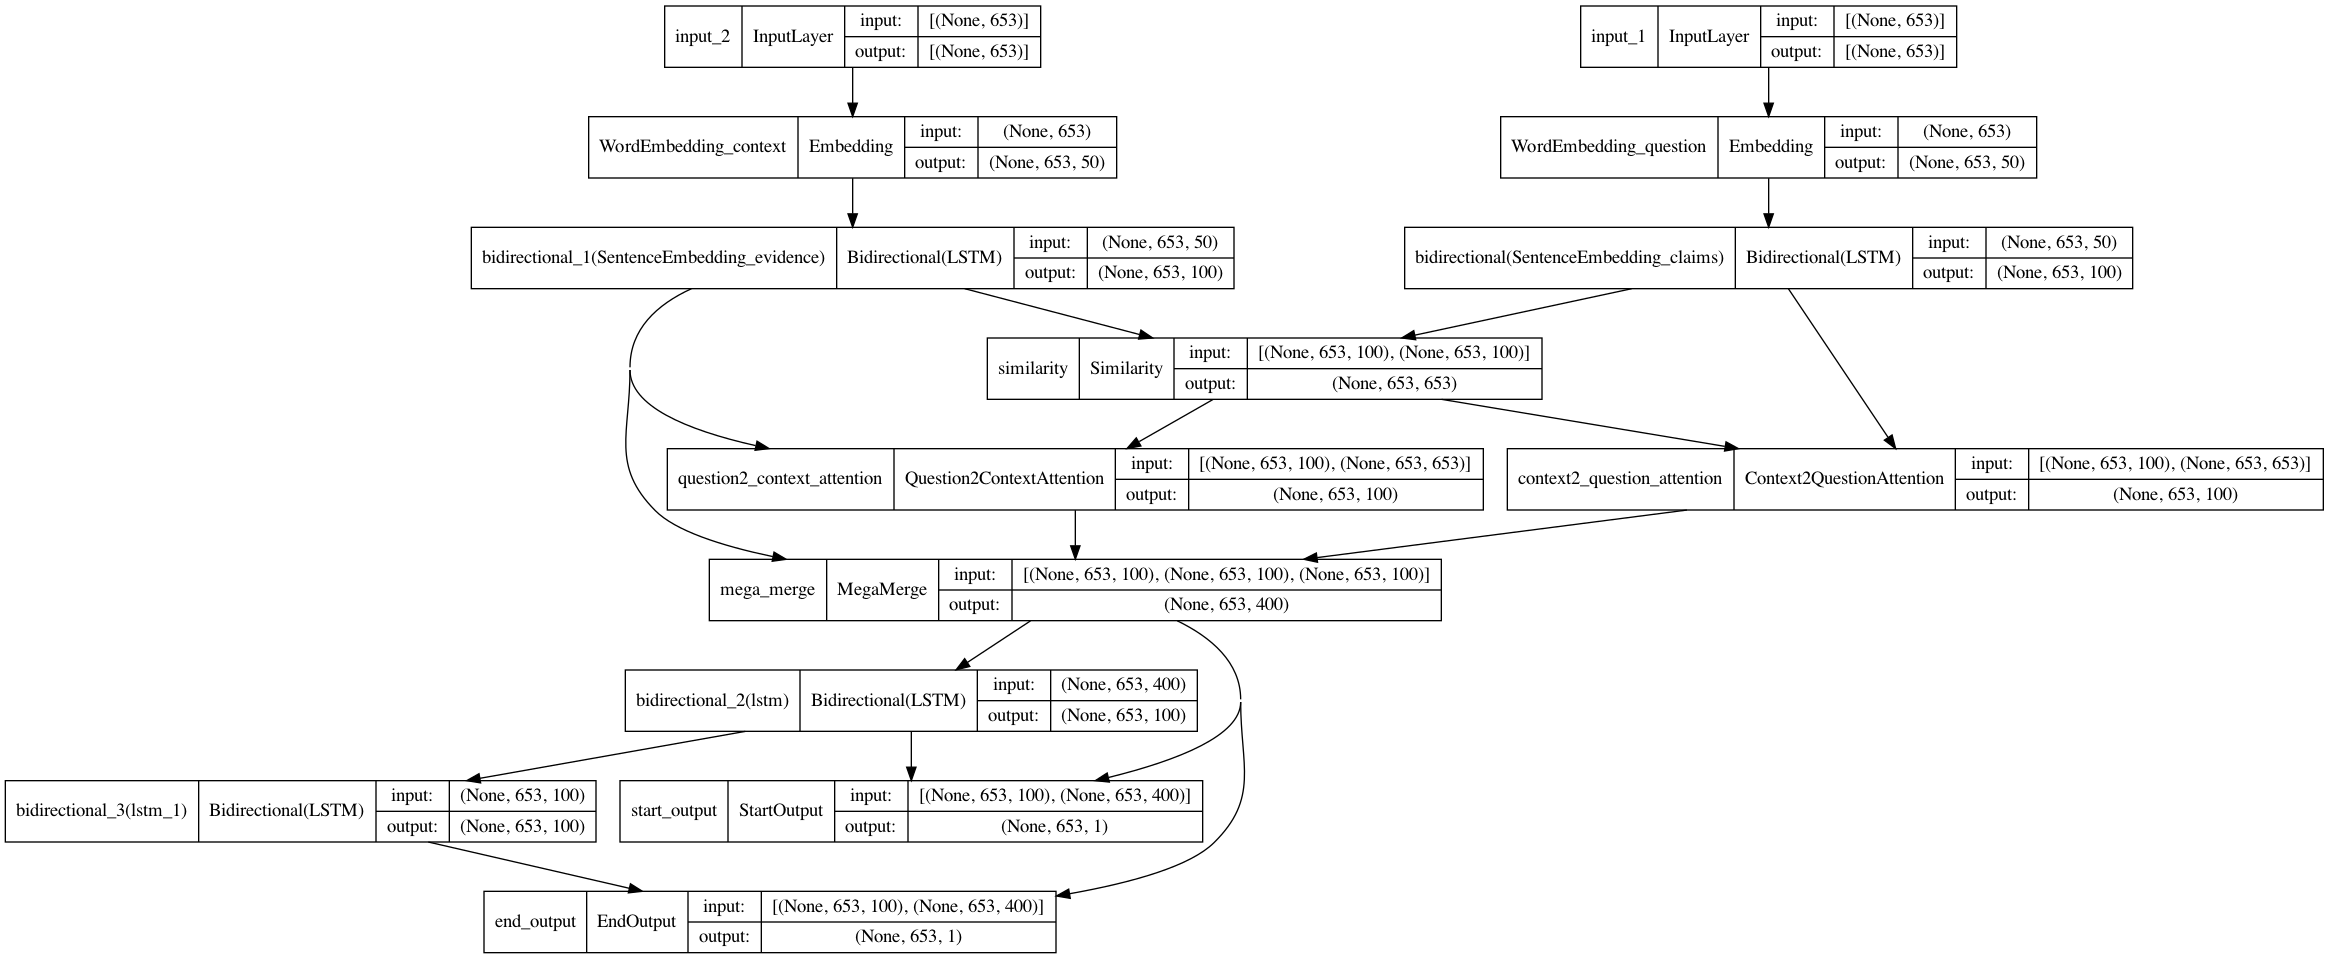

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history

In [ ]:
q = np.array([[[1,2, 3], [1,2, 3]], [[1,2, 3], [1,2, 3]]])
K.shape(q)[1]

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
q = np.array([1,2,3])

In [ ]:
ex = K.expand_dims(q, axis=0)

In [ ]:
ex

<tf.Tensor: shape=(1, 2, 2, 3), dtype=int64, numpy=
array([[[[1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3]]]])>

In [ ]:
K.tile(ex, context_dim_repeat)

<tf.Tensor: shape=(1, 2, 12, 3), dtype=int64, numpy=
array([[[[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]],

        [[1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3],
         [1, 2, 3]]]])>

In [ ]:
context_dim_repeat = K.concatenate([[1, 1], [6], [1]], 0)

In [ ]:
context_dim_repeat

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 1, 5, 1], dtype=int32)>

In [ ]:
n1 = np.random.rand(10,653, 653, 100))
n2 = np.random.rand(10,653, 653, 100)
n3 = np.random.rand(10,653, 653, 100)

TypeError: _to_tensor() missing 1 required positional argument: 'dtype'

In [ ]:
n1 = tf.convert_to_tensor(n1)
n2 = tf.convert_to_tensor(n2)
n3 = tf.convert_to_tensor(n3)


In [ ]:
concatenated_tensor = K.concatenate([n1, n2, n3], axis=-1)

### Funcitons for saving, predicting, plotting and evaluating the models


#### Save model

In [ ]:
def save_model(model, sentence_embedding_type=1, merge_type=1, dir='models'):
    '''
        Saves model naming it according to sentence embedding merge type and time stamp.
    '''
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H:%M:%S")
    model_name = f'model_SE{sentence_embedding_type}_MT{merge_type}_{dt_string}'
    path = f'{dir}/{model_name}'
    model.save(path)

#### Get predicitons

In [ ]:
def prediction(model: keras.Model, x, predicting_info):
    '''Call the models prediction function'''
    predictions = model.predict(x, **predicting_info)
    return predictions

#### Plot accuracy and loss

In [ ]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

#### Fucniton for multi-input classification evaluation

In [ ]:
def evaluation(predictions):
    '''
        Function for plotting the confusion_matrix
        Inputs:
            predicitons: Predicitons from a keras model
    '''
    print(classification_report(y_test, predictions))
    print(accuracy_score(y_test, predictions))
    cf_matrix = confusion_matrix(y_test, predictions)
    plot_confusion_matrix(cf_matrix)

#### Funcitons for claim verification evaluation

In [ ]:
def make_claims_dict():
    """
    Makes a dictionary with claimID as key and 
    a list of the index for every evidence 
    corresponding to the claim as value
    """
    claims = {}
    t = test_df.groupby("claimID")
    for name, group in t:
        claims[name] = list(group.index)
    return claims

In [ ]:
def majority_pred(predictions):
    """
    Find predictions based on majority voting
    """
    majority = []

    for i in range(len(claim_test)):
        claim_id = np.array(test_df['claimID'])[i]
        support = 0
        defutes = 0
        for evidence in claims_dict[claim_id]:
            if predictions[evidence] == 1:
                support += 1
            else:
                defutes += 1
        if support > defutes:
            majority.append(1.0)
        else:
            majority.append(0.0)
    return majority

In [ ]:
save_model(model)

2021-12-10 20:01:24.769048: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/model_SE1_MT1_10_12_2021_20:00:59/assets


INFO:tensorflow:Assets written to: models/model_SE1_MT1_10_12_2021_20:00:59/assets


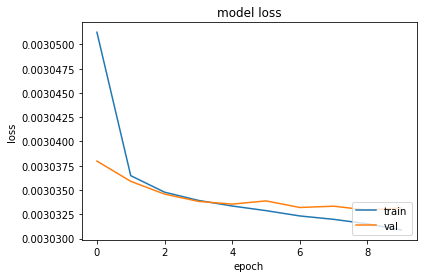

KeyError: 'acc'

In [ ]:
plot_loss(history)
plot_accuracy(history)